<a href="https://colab.research.google.com/github/andrewkang12345/PeakOilRatePredictor/blob/main/PeakOilRatePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rice Datathon 2024: Chevron Track
#### Predicting the "Oil Peak Rate" variable with Chevron Data

After experimenting with Ridge, Lasso, neural networks, autoencoders, KNN, decision trees, and ensemble learning, we constructed the methodology below.

## Final Methodology:
- Use DBScan to cluster datapoints based on the x and y coordinate features
- Train XGBoost on each cluster
- Final RMSE: Around 90.4

## Import Modules

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns


In [ ]:
from google.colab import drive

drive.mount('/content/drive')
# path = "copied path"
# df_bonus = pd.read_csv(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/chevronTraining.csv"
training = pd.read_csv(path)
training.drop(columns=['Unnamed: 0', 'pad_id'], inplace=True)
training = training.dropna(subset=['OilPeakRate'])


## Basic Preprocessing

In [ ]:
training.replace([np.inf, -np.inf], np.nan, inplace=True)

numeric_cols = training.select_dtypes(include=['number']).columns
training[numeric_cols] = training[numeric_cols].fillna(training[numeric_cols].median())

categorical_cols = training.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(training, columns=categorical_cols)

print(df_encoded.columns)

X = df_encoded.drop(columns=['OilPeakRate'])
y = df_encoded['OilPeakRate']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled[y.name] = y.values
df_encoded = df_scaled

X = df_encoded.drop(columns=['OilPeakRate'])
y = df_encoded['OilPeakRate']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Index(['surface_x', 'surface_y', 'bh_x', 'bh_y', 'standardized_operator_name',
       'gross_perforated_length', 'number_of_stages', 'total_proppant',
       'total_fluid', 'true_vertical_depth', 'proppant_intensity',
       'frac_fluid_intensity', 'average_stage_length',
       'average_proppant_per_stage', 'average_frac_fluid_per_stage',
       'proppant_to_frac_fluid_ratio', 'frac_fluid_to_proppant_ratio',
       'bin_lateral_length', 'frac_seasoning', 'horizontal_midpoint_x',
       'horizontal_midpoint_y', 'horizontal_toe_x', 'horizontal_toe_y',
       'OilPeakRate', 'ffs_frac_type_Crosslink Only',
       'ffs_frac_type_Linear Only',
       'ffs_frac_type_Slickwater Crosslink Hybrid',
       'ffs_frac_type_Slickwater Linear Hybrid',
       'ffs_frac_type_Slickwater Only', 'ffs_frac_type_Undefined',
       'relative_well_position_Inner Well',
       'relative_well_position_Outer Well',
       'relative_well_position_Standalone Well',
       'relative_well_position_Unknown',
       

## Oil Peak Rate Distribution

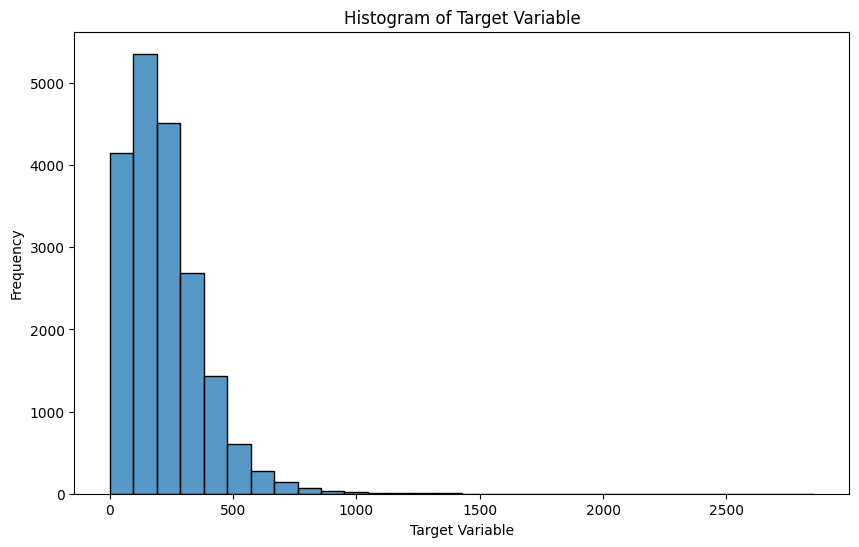

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=False, bins=30)
plt.title('Histogram of Oil Peak Rates')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.show()

## Ridge & LASSO Optimization

In [ ]:
param_grid = {'alpha': np.logspace(-4, 4, 50)}
ridge = Ridge()

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
best_alpha = grid_search.best_params_['alpha']

best_ridge = Ridge(alpha=best_alpha)
best_ridge.fit(X_train, y_train)

y_pred = best_ridge.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Root Mean Squared Error: {rmse}')



# Using Ridge only!


Best parameters:  {'alpha': 4714.8663634573895}
Root Mean Squared Error: 119.90956201083232


In [ ]:
from sklearn.linear_model import Lasso


In [ ]:
param_grid = {'alpha': np.logspace(-4, 4, 50)}

lasso = Lasso()

grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
best_alpha = grid_search.best_params_['alpha']

best_lasso = Lasso(alpha=best_alpha)
best_lasso.fit(X_train, y_train)

y_pred = best_lasso.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')



# Using Lasso only!
# Best parameters:  {'alpha': 7.9060432109076855}
# Mean Squared Error: 14943.406960021272

## XGBoost (Naive)

In [ ]:
import xgboost as xgb

In [ ]:
X = df_encoded.drop(columns=['OilPeakRate'])  # Assuming the last column is the target
y = df_encoded['OilPeakRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xg_reg = xgb.XGBRegressor()

param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 10],
    'alpha': [1, 10],
    'n_estimators': [50, 150],
    }

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_xg_reg = xgb.XGBRegressor(**grid_search.best_params_)
best_xg_reg.fit(X_train, y_train)

y_pred = best_xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'alpha': 10, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}
Root Mean Squared Error: 94.9892548359684


## Neural Networks & Autoencoders (Minimized for readability)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
# Neural networks & Autoencoder results in worse RMSE! (around 110)

Epoch 1, Loss: 0.9958111047744751
Epoch 6, Loss: 0.9898871183395386
Epoch 11, Loss: 0.9839284420013428
Epoch 16, Loss: 0.974962055683136
Epoch 21, Loss: 0.9605249762535095
Epoch 26, Loss: 0.9372918009757996
Epoch 31, Loss: 0.9018574357032776
Epoch 36, Loss: 0.8548372387886047
Epoch 41, Loss: 0.8061277866363525
Epoch 46, Loss: 0.76531982421875


## Data Exploration and Clustering of Location features

In [ ]:
from sklearn.decomposition import PCA


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


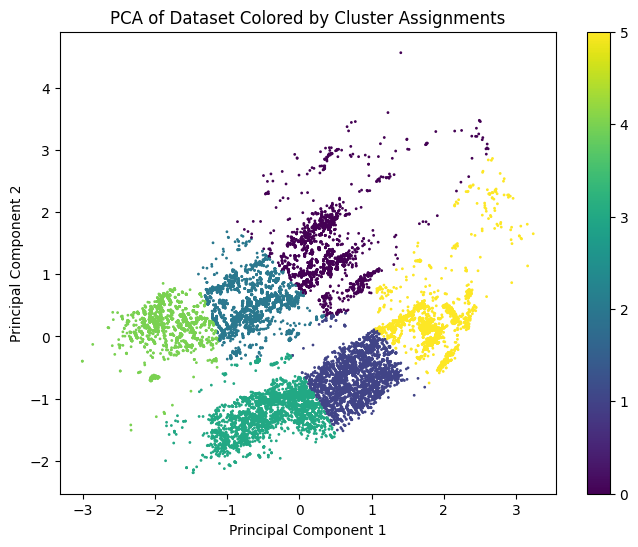

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[['surface_x', 'surface_y']])

kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X[['surface_x', 'surface_y']])

pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = clusters  # Add cluster assignments

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='viridis', s=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset Colored by Cluster Assignments')
plt.colorbar(scatter)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN


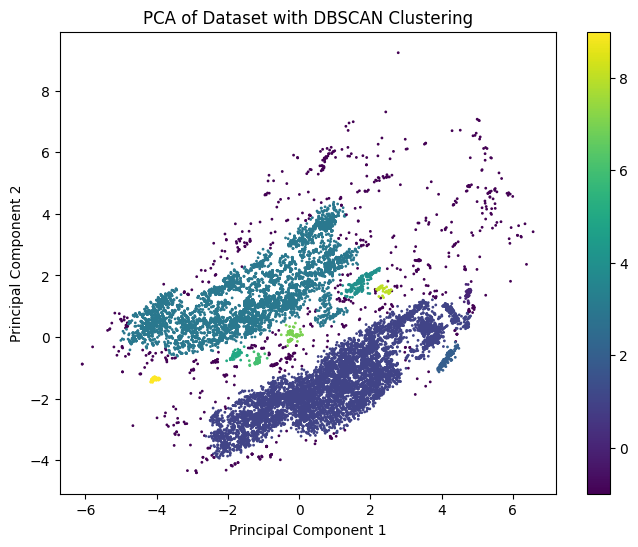

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[['surface_x', 'surface_y', 'bh_x', 'bh_y', 'horizontal_midpoint_x',
                             'horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y']])

dbscan = DBSCAN(eps=0.21, min_samples=30)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(X_pca)

pca_df = pd.DataFrame(data=X_pca, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = clusters  # Add cluster assignments

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='viridis', s=1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Dataset with DBSCAN Clustering')
plt.colorbar(scatter)
plt.show()



In [ ]:
combined_df = pd.concat([X,y], axis=1)

## XGBoost on DBScan - Optimization

In [ ]:
import xgboost as xgb

In [ ]:
for i in range(28, 33, 1):
  for j in np.arange(0.01, 1, 0.1):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X[['surface_x', 'surface_y', 'bh_x', 'bh_y', 'horizontal_midpoint_x',
                             'horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y']])
    dbscan = DBSCAN(eps=j, min_samples=i)
    clusters = dbscan.fit_predict(X_pca)

    combined_df['Cluster'] = clusters

    total_rmse = 0
    total_samples = 0

    unique_clusters = np.unique(clusters)
    for cluster in unique_clusters:
        cluster_data = combined_df[combined_df['Cluster'] == cluster]
        X_cluster = cluster_data.drop(columns=['OilPeakRate', 'Cluster'])
        y_cluster = cluster_data['OilPeakRate']

        X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

        xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
        xgb_model.fit(X_train, y_train)

        y_pred = xgb_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        total_rmse += rmse * len(y_test)
        total_samples += len(y_test)

    total_rmse /= total_samples
    print(f'Total RMSE across all clusters: {total_rmse}, min: {i}, eps: {j}')

# WITH ALL FEATURES
# Total RMSE across all clusters: 93.13515700255566, min: 5, eps: 0.41000000000000003
# Total RMSE across all clusters: 93.09983262942829, min: 12, eps: 0.51

# WITH PCA on LOCATION FEATURES
# Total RMSE across all clusters: 90.48362211987636, min: 30, eps: 0.21000000000000002

Total RMSE across all clusters: 97.49381464322784, min: 28, eps: 0.01
Total RMSE across all clusters: 92.83099094175604, min: 28, eps: 0.11
Total RMSE across all clusters: 98.62547217544956, min: 28, eps: 0.21000000000000002
Total RMSE across all clusters: 96.93113438653018, min: 28, eps: 0.31000000000000005
Total RMSE across all clusters: 99.74104227705027, min: 28, eps: 0.41000000000000003
Total RMSE across all clusters: 99.42021393234988, min: 28, eps: 0.51
Total RMSE across all clusters: 96.52761696007902, min: 28, eps: 0.6100000000000001
Total RMSE across all clusters: 97.39603415094305, min: 28, eps: 0.7100000000000001
Total RMSE across all clusters: 102.53609260882492, min: 28, eps: 0.81
Total RMSE across all clusters: 100.78908899913866, min: 28, eps: 0.91
Total RMSE across all clusters: 97.49381464322784, min: 29, eps: 0.01
Total RMSE across all clusters: 103.7107421844419, min: 29, eps: 0.11
Total RMSE across all clusters: 97.1197511328849, min: 29, eps: 0.21000000000000002
T

## Distribution of Oil Peak Rates for each Cluster (Optimized)

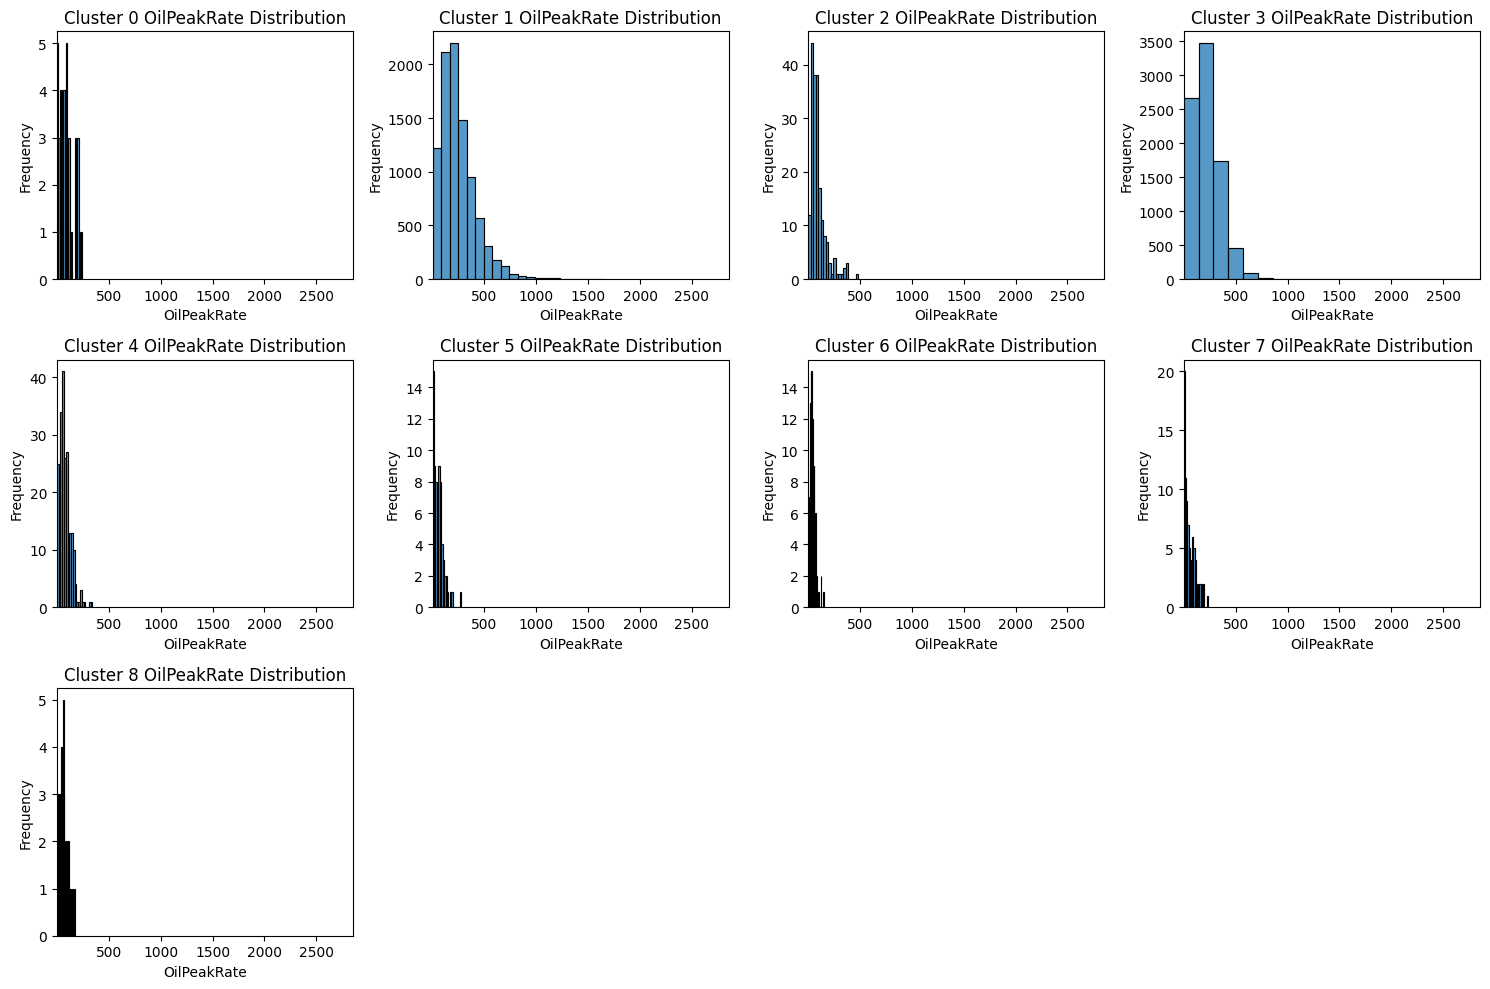

In [ ]:
plt.figure(figsize=(15, 10))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X[['surface_x', 'surface_y', 'bh_x', 'bh_y', 'horizontal_midpoint_x',
                          'horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y']])
dbscan = DBSCAN(eps=0.21, min_samples=30)
clusters = dbscan.fit_predict(X_pca)

combined_df['Cluster'] = clusters


global_min = combined_df['OilPeakRate'].min()
global_max = combined_df['OilPeakRate'].max()


for i in range(max(clusters)):
    plt.subplot(3, 4, i+1)  # Adjust the grid dimensions (3, 4) as needed
    cluster_data = combined_df[combined_df['Cluster'] == i]['OilPeakRate']
    sns.histplot(cluster_data, kde=False, bins=20)
    plt.xlim(global_min, global_max)

    plt.title(f'Cluster {i} OilPeakRate Distribution')
    plt.xlabel('OilPeakRate')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## K-means clustering proved worse than DBScan

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

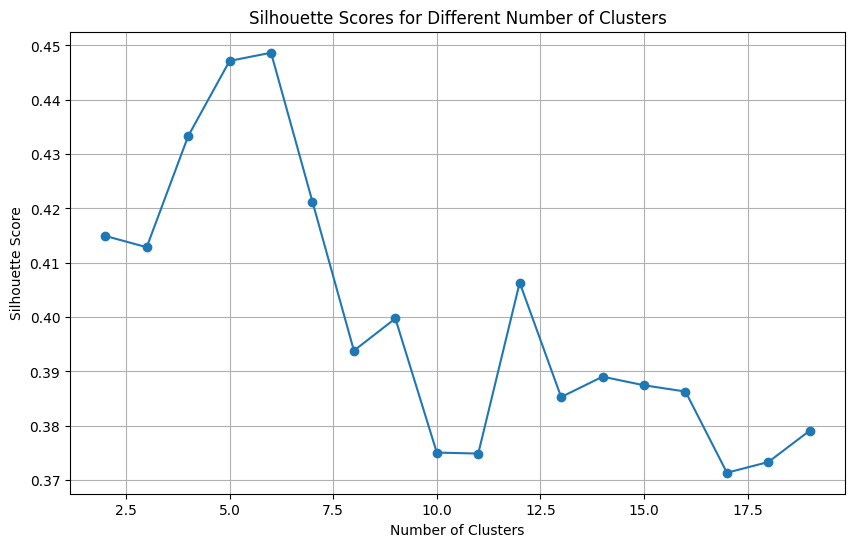

In [ ]:
range_n_clusters = range(2, 20)

silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(combined_df[['surface_x', 'surface_y', 'bh_x', 'bh_y']])

    silhouette_avg = silhouette_score(combined_df[['surface_x', 'surface_y', 'bh_x', 'bh_y']], cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)


plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title('Silhouette Scores for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

## K means: Averages per Cluster (6 vs 12 clusters)

In [ ]:
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(combined_df[['surface_x', 'surface_y', 'bh_x', 'bh_y']])

combined_df['Cluster'] = clusters

cluster_averages = combined_df.groupby('Cluster')['OilPeakRate'].mean()

print(cluster_averages)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
0    228.943010
1    228.223249
2    263.387252
3    132.408387
4    150.191739
5    240.461276
Name: OilPeakRate, dtype: float64


In [ ]:
kmeans = KMeans(n_clusters=12, random_state=42)
clusters = kmeans.fit_predict(combined_df[['surface_x', 'surface_y', 'bh_x', 'bh_y']])

combined_df['Cluster'] = clusters

cluster_averages = combined_df.groupby('Cluster')['OilPeakRate'].mean()

print(cluster_averages)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
0     265.961969
1     222.614607
2     119.621376
3     200.715604
4     157.698767
5     209.043995
6     279.300252
7     258.298242
8     255.727217
9      42.270714
10    220.600528
11    206.223166
Name: OilPeakRate, dtype: float64


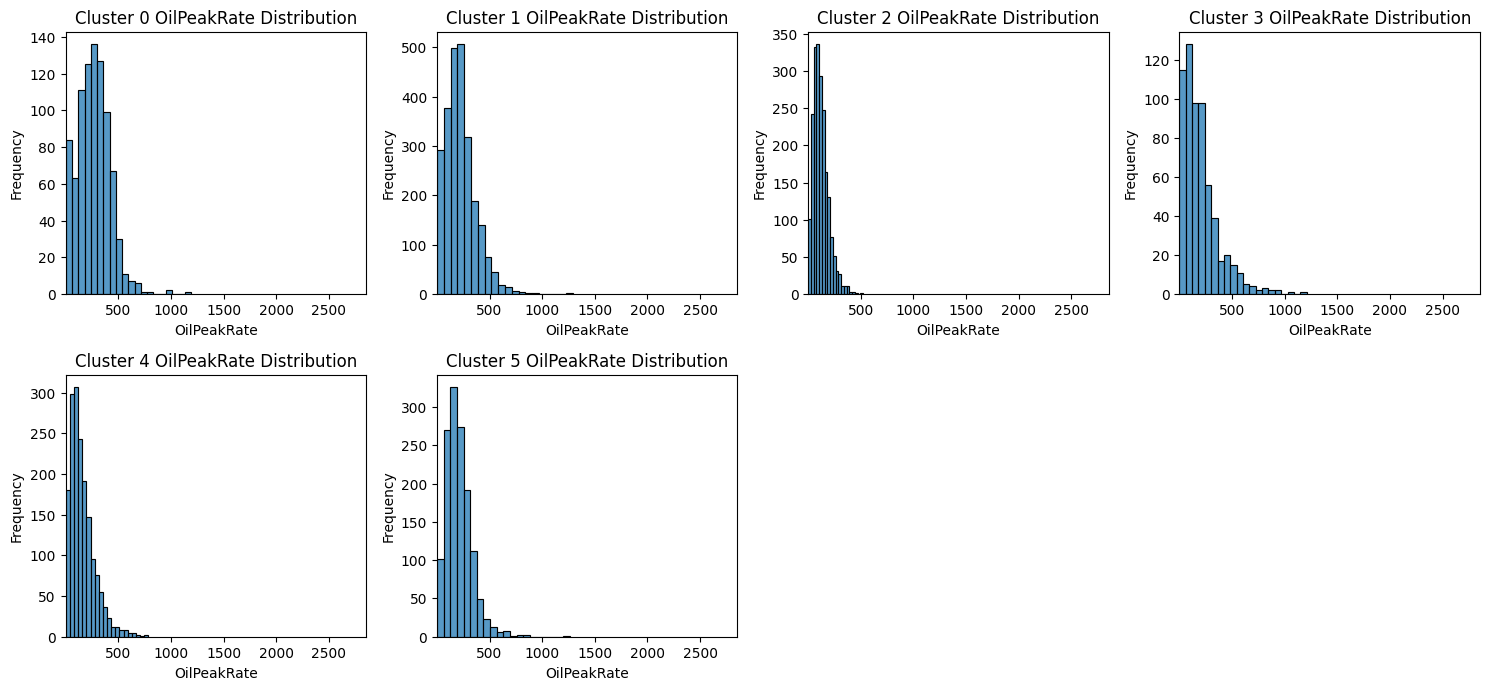

In [ ]:
plt.figure(figsize=(15, 10))

n_clusters = 6

global_min = combined_df['OilPeakRate'].min()
global_max = combined_df['OilPeakRate'].max()

for i in range(n_clusters):
    plt.subplot(3, 4, i+1)  # Adjust the grid dimensions (3, 4) as needed
    cluster_data = combined_df[combined_df['Cluster'] == i]['OilPeakRate']
    sns.histplot(cluster_data, kde=False, bins=20)
    plt.xlim(global_min, global_max)

    plt.title(f'Cluster {i} OilPeakRate Distribution')
    plt.xlabel('OilPeakRate')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## XGBoost after K Means (worse than DBScan)

In [ ]:
import xgboost as xgb

In [ ]:
total_rmse = 0
total_samples = 0

for i in range(6):
    cluster_data = combined_df[combined_df['Cluster'] == i]
    X_cluster = cluster_data.drop(columns=['OilPeakRate'])
    y_cluster = cluster_data['OilPeakRate']

    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', alpha= 10, learning_rate= 0.1, max_depth= 10, n_estimators= 150)

    xg_reg.fit(X_train, y_train)

    y_pred = xg_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Cluster {i} RMSE: {rmse}')

    total_rmse += rmse * len(y_test)
    total_samples += len(y_test)

total_rmse /= total_samples
print(f'Total RMSE across all clusters: {total_rmse}')

Cluster 0 RMSE: 115.38489837814274
Cluster 1 RMSE: 101.85230021146705
Cluster 2 RMSE: 54.84284252752465
Cluster 3 RMSE: 147.46000637515013
Cluster 4 RMSE: 94.5809284199662
Cluster 5 RMSE: 120.50817209808709
Total RMSE across all clusters: 97.06417124602868


In [ ]:
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', alpha= 10, learning_rate= 0.1, max_depth= 10, n_estimators= 150)
    xg_reg.fit(X_train, y_train)
    y_pred = xg_reg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse, len(y_test)

cluster_sets = {
    'Cluster 2': combined_df[combined_df['Cluster'] == 2],
    'Cluster 4': combined_df[combined_df['Cluster'] == 4],
    'The Rest': combined_df[~combined_df['Cluster'].isin([2, 4])]
}

total_rmse = 0
total_samples = 0

for cluster_name, cluster_data in cluster_sets.items():
    X = cluster_data.drop(columns=['OilPeakRate','surface_x', 'surface_y', 'bh_x', 'bh_y'])
    y = cluster_data['OilPeakRate']
    rmse, sample_count = train_and_evaluate(X, y)
    total_rmse += rmse * sample_count
    total_samples += sample_count
    print(f'{cluster_name} RMSE: {rmse}')

total_rmse /= total_samples
print(f'Total RMSE across all cluster sets: {total_rmse}')

Cluster 2 RMSE: 53.198094098436094
Cluster 4 RMSE: 95.33687083212682
The Rest RMSE: 98.70096394614613
Total RMSE across all cluster sets: 93.52522392492745


## KNN Regressor Optimization

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
X = combined_df[['surface_x', 'surface_y', 'bh_x', 'bh_y', 'horizontal_midpoint_x',
                             'horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y']]
y = combined_df['OilPeakRate']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

for i in range(1, 100, 5):
  knn_regressor = KNeighborsRegressor(n_neighbors=i)  # You can adjust the number of neighbors

  knn_regressor.fit(X_train, y_train)

  y_pred = knn_regressor.predict(X_test)

  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print(f'Test RMSE: {rmse}')

Test RMSE: 137.71015756030963
Test RMSE: 113.0203012146785
Test RMSE: 112.25682931613088
Test RMSE: 112.94350905098428
Test RMSE: 113.60283438335838
Test RMSE: 114.41687620226018
Test RMSE: 115.10517439891895
Test RMSE: 115.5554910169017
Test RMSE: 116.0824660413503
Test RMSE: 116.51457880498434
Test RMSE: 116.8437539309811
Test RMSE: 117.15048964139591
Test RMSE: 117.48602764668588
Test RMSE: 117.64781300910063
Test RMSE: 117.9221395428758
Test RMSE: 118.18823479597373
Test RMSE: 118.47369762701227
Test RMSE: 118.58524623882366
Test RMSE: 118.77340559162164
Test RMSE: 118.90036199620222


## Ensemble Learning Experimentation

In [ ]:
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge

In [ ]:
X = combined_df.drop(columns=['OilPeakRate'])
y = combined_df['OilPeakRate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
ridge_model = Ridge(alpha=4714.8663634573895)

voting_ensemble = VotingRegressor(estimators=[
    ('xgboost', xgboost_model),
    ('random_forest', random_forest_model),
    ('ridge', ridge_model)
])

voting_ensemble.fit(X_train, y_train)

y_pred = voting_ensemble.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Ensemble Test RMSE: {rmse}')

Ensemble Test RMSE: 98.47590735204668
